# Understanding relations between variables 
## A gentle introduction to correlation and regression for historians 
### ... in Python and Pandas

This chapter turns to more advanced but also more scientifically interesting and contested topics for historians. We will discuss the topic of modelling using linear or generelaized linear models.

This is only an introduction, as with the previous lecture we propose further reading, but

- What are doing when building a regression model?
- How to square the mechanistic assumptions and functions of a model with and historical (or just common sense) knowledge and reasoning?

More practically:

- How to train and intepret a model?

## Understanding relations between variables: Age and Wealth in late Victorian London

In this lecture we continue building on the data we used previously: we'd like to investigate the distribution of age in London, but explaining and predicting variation in age.

We are specifically interesting in the relation between wealth and age. We have two two dataframes
- the mean each in each district (aggregated by gender)
- the rateable value per capita for each borough

The first case study discussed in this lecture should not be interpreted as realistic research example, it is too problematic for that. However, we hope it will demonstrate multiple practical and philosophical problems (and opportunities) that aries when applying regression to historical data and questions.

Of course, the first step is the load the required tool we will need later on in this notebook.

In [291]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import matplotlib.pyplot as plt
sns.set()

Before we turn to the actual analysis, let's discuss some common data wrangling steps that characterize, and often problematize, data rich research in history. 

First we create a new dataframe the records the mean age and number of observiations for each district.

In [305]:
df = pd.read_csv('data/icem/EW01_london_subsample.csv',index_col=0)
df.head()

,RegDist,SubDist,Sex,Age,DisCode1
0,Kensington,Kensington Town,M,18,0
1,Greenwich,Deptford South,U,14,0
2,St George Hanover Square,St Margaret And St John,M,38,0
3,St Olave Southwark,Bermondsey,F,42,0
4,St George Hanover Square,St Margaret And St John,M,19,0


In [997]:
df.Age.mean()

27.786728095422067

In [353]:
age_by_dist = df.groupby(['RegDist']).agg({'Age':'mean','Sex':'count'})

In [1055]:
age_by_dist = df.groupby(['RegDist']).agg({'Age':lambda x: np.mean(x > 60),'Sex':'count'})

In [1056]:
age_by_dist

,Age,Sex
RegDist,,
Bethnal Green,0.054189,31593
Camberwell,0.061101,63060
Chelsea,0.091494,18329
Fulham,0.055481,60489
Greenwich,0.060359,44832
Hackney,0.066741,65687
Hampstead,0.064821,20117
Holborn,0.054023,31320
Islington,0.064808,81826


We can do the same but now disagregating by gender.

In [1057]:
age_by_dist_gen = df.groupby(['RegDist','Sex']).agg({'Age':'mean','Sex':'count'})
age_by_dist_gen = df.groupby(['RegDist','Sex']).agg({'Age':lambda x: np.mean(x > 50),'Sex':'count'})

In [1058]:
age_by_dist_gen.loc['Bethnal Green']

,Age,Sex
Sex,,
F,0.122878,16081
M,0.113501,14458
U,0.089184,1054


To understand the relation between how wealthy a place is and the average age of the people living in that location we need to add additional information to our dataframe. 

The dataframe below capture the rateable value per capita in each London borough (the data is synthetic but follows the pattern of a 'real' values collected for 1922.

Rateable value per capita is proxy for [...].

The latter is something prevalent in statistical research where we use variables as standing in for some phenomemen you want to explain. This topic is also called **construct validity**.

In [1059]:
rv = pd.read_csv('./data/icem/rateable_value.csv',index_col=0)
rv.head()

,borough,rateable_value_pc
0,Battersea,6.1
1,Bermondsey,8.5
2,Bethnal Green,4.9
3,Camberwell,5.2
4,Chelsea,14.7


We want to merge the dataframes together but first we should check to what extent this is possible, both practically and theoretically.

- What names occur in both datasets? We will use these to combine information from heterogeneous sources.
- To what extent are the districts that appear in the census the same as the boroughs in the data on rateable value per capita?

First we want check which place names appear in both datasets

We create a Python `set`, a list of unique values, for the place names in both dataframes.

We first take the column that records place names and  we convert this to a set of unique names.

In [1060]:
d1_pl = set(df['RegDist'])
print(d1_pl)

{'St George Hanover Square', 'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Camberwell', 'Lambeth', 'Lewisham', 'St George In The East', 'Kensington', 'Westminster', 'Bethnal Green', 'St Giles', 'Paddington', 'London City', 'Holborn', 'Hampstead', 'St Olave Southwark', 'Islington', 'Marylebone', 'Strand', 'Greenwich', 'Southwark', 'Mile End Old Town', 'Fulham', 'Wandsworth', 'Woolwich', 'Whitechapel'}


In [1061]:
d2_pl = set(rv['borough'])
print(d2_pl)

{'Battersea', 'Deptford', 'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Stoke Newington', 'Camberwell', 'Lambeth', 'Lewisham', 'Hammersmith', 'Bermondsey', 'Finsbury', 'Kensington', 'Westminster', 'Bethnal Green', 'Paddington', 'Holborn', 'Hampstead', 'Islington', 'Marylebone', 'Greenwich', 'Fulham', 'Southwark', 'Wandsworth', 'Woolwich'}


After getting these two sets we compute their intersection, i.e. the names that appear in both dataframes.

The syntax is set1.intersection(set2). We basically apply the `.intersection()` to a set and pass another set as argument.

In [1062]:
print(d1_pl.intersection(d2_pl))

{'Pancras', 'Shoreditch', 'Poplar', 'Stepney', 'Chelsea', 'Hackney', 'Camberwell', 'Lambeth', 'Lewisham', 'Kensington', 'Westminster', 'Bethnal Green', 'Paddington', 'Holborn', 'Hampstead', 'Islington', 'Marylebone', 'Greenwich', 'Fulham', 'Southwark', 'Wandsworth', 'Woolwich'}


In [1063]:
d1_pl - d2_pl

{'London City',
 'Mile End Old Town',
 'St George Hanover Square',
 'St George In The East',
 'St Giles',
 'St Olave Southwark',
 'Strand',
 'Whitechapel'}

In [1064]:
d2_pl - d1_pl

{'Battersea',
 'Bermondsey',
 'Deptford',
 'Finsbury',
 'Hammersmith',
 'Stoke Newington'}

Now we can go ahead and merge the data. However, be careful: it is not because the strings match that they mean the same thing. Don't worry about the syntax we will explain it in more detail below.

In [1065]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,Sex,borough,rateable_value_pc
2,0.054189,31593,Bethnal Green,4.9
3,0.061101,63060,Camberwell,5.2
4,0.091494,18329,Chelsea,14.7
7,0.055481,60489,Fulham,6.1
8,0.060359,44832,Greenwich,7.6
9,0.066741,65687,Hackney,5.7
11,0.064821,20117,Hampstead,13.3
12,0.054023,31320,Holborn,32.0
13,0.064808,81826,Islington,5.7
14,0.071808,43115,Kensington,14.4


`.merge` is a very, very useful method to combine dataframes based on shared information. More precisely, a shared variable or columns. What we did in the previous code, was adding information from `rv` to `age_by_dist`. As we shown before, both share a columns that have similar values, namely place names in London. We use the values to combine dataframes, i.e. rows that have the value `Bethnal Green` in the `age_by_dist` dataframes will be joined by those

Please notice that the name of the columns can be different but the values in the columns have to overlap.

Below we show a simple toy example slight adapted from very thorough Pandas [documentation](https://pandas.pydata.org/docs/reference/api/pandas.merge.html).

Imagine that I recorded the number of cats and dogs I spotted each day, but keep this information in two separate dataframes.

In [1066]:
df1 = pd.DataFrame({'day': ['mon', 'tue', 'wed', 'thu'],
                    'cats': [1, 2, 3, 5]})
df2 = pd.DataFrame({'dayz': ['mon', 'tue', 'wed', 'thu'],
                    'dogs': [5, 6, 7, 8]})

In [1067]:
df1

,day,cats
0,mon,1
1,tue,2
2,wed,3
3,thu,5


In [1068]:
df2

,dayz,dogs
0,mon,5
1,tue,6
2,wed,7
3,thu,8


As you notice both dataframes have a column that records that day of the week, even though the column name slightly differz. We can combine these dataframes into one with `left_df.merge(right_df)` method. This method is apply to a dataframe at the left hand side (before the dot) and one at the right hand side passed as an argument to the method.

To merge properly, we have to instruct Pandas by telling which columns we want to use for combining information. `left_on` indicates the column name we use in the dataframe at the left hand side of the `.merge()` method.

In [1069]:
df1.merge(df2, left_on='day', right_on='dayz')

,day,cats,dayz,dogs
0,mon,1,mon,5
1,tue,2,tue,6
2,wed,3,wed,7
3,thu,5,thu,8


Sometimes we want merge using the index of a dataframe instead of a column. In this case we use the argument `left_index` (or `right_index`) and takes a boolean (`True` or `False` as value).

To revisit a previous line of code, which should be more understable at this point: the line below merges `age_by_dist` (left) with `rv`. For the left dataframe we use the index (`left_index=True`), for the right one a column named `'borough'` (`right_on='borough'`).

In [1070]:
data_merged = age_by_dist.merge(rv,left_index=True,right_on='borough')
data_merged

,Age,Sex,borough,rateable_value_pc
2,0.054189,31593,Bethnal Green,4.9
3,0.061101,63060,Camberwell,5.2
4,0.091494,18329,Chelsea,14.7
7,0.055481,60489,Fulham,6.1
8,0.060359,44832,Greenwich,7.6
9,0.066741,65687,Hackney,5.7
11,0.064821,20117,Hampstead,13.3
12,0.054023,31320,Holborn,32.0
13,0.064808,81826,Islington,5.7
14,0.071808,43115,Kensington,14.4


##  Correlation

Having combined information from these dataframes, we can explore the relation between variables. Let's start with the most the most obvious point: correlation. 

Correlation tells us the extent to which two variables are related. Imagine I collect the number of dogs I observed in a variable `v1` and the daily cats in `v2`. If there is a correlation between cats and dogs on the street, I expect the to see many (of few) dogs and cats on the same days, or if the number of daily spotted dogs is up, so does the number of cats.

To inspect the correlation visually we can make a scatterplot. This plots for each value in `v1` the corresponding value in `v2`. For example the first point in the figure below looks at the first value in both vector. The x value is 1 and the y value is 2 producing at point (1,2). **[rephrase]**

In [1071]:
v1 = [1,3,5,7,2,6]
v2 = [2,4,8,7,3,5]

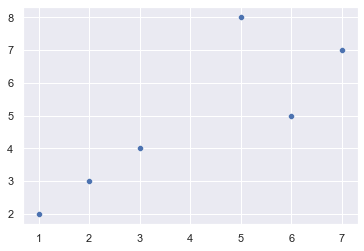

In [1072]:
sns.scatterplot(x=v1,y=v2)

The figure suggests a strong correlation between `v1` and `v2`, i.e. we observe hight values for y when x is high. 

However nice, we'd like to put a number on this, the expressess the strength of this relation, so we can compare if other vectors are stronger correlated.


We can compute the strength of this relation between using Pearson correlation coefficient.

Please notice that computing correlation is based on an implicit alignment of the tow vectors. Each position captures the same days. If the order in v2 would be different (for example starts at Wednesday) I could technically still make a scatterplot and computer correlation but the results would be meaningless (or at least not match the intention).


### Pearson correlation coefficient

A widely used measure to compute the relation between to arrays or vectors is the pearsion correlation coefficient. This coefficient will vary between -1 and +1, meaning a strong negative respectively positive correlation.


Below we will show how to compute it yourself, but as you can guess, there exist method in Pandas.

However, showing the process is good to demystify such measures.

We need a few ingredients to compute the pearson correlation coeffient. First we need to compute the mean for each vector and their standard deviation. We also need to normalize by the amount of data we have, for this we need to record `n` the number of observations (this is equaly to the length of `v1` (or `v2`, remember both are aligned and equal in length).

In [1073]:
mean_v1 = np.mean(v1)
mean_v2 = np.mean(v2)
std_v1 = np.std(v1)
std_v2 = np.std(v2)
n = len(v1)

Next, for each vector we substract each value with the mean of the vector

In [1074]:
sub_mean_v1 = [i - mean_v1 for i in v1]
sub_mean_v2 = [i - mean_v2 for i in v2]

In [1075]:
sub_mean_v1,sub_mean_v2

([-3.0, -1.0, 1.0, 3.0, -2.0, 2.0],
 [-2.833333333333333,
  -0.833333333333333,
  3.166666666666667,
  2.166666666666667,
  -1.833333333333333,
  0.16666666666666696])

Then we compute the position-wise product of the value in `sub_mean_v1` and `sub_mean_v2`, i.e we we multiple the first position in `sub_mean_v1` with the value in the corresponding postion in `sub_mean_v1`.

A convenient function here is `zip()` which as the name suggest zips two lists based on the index. For example if we `zip` `sub_mean_v1` and `sub_mean_v1` we get:

In [1076]:
diffs_zipped = list(zip(sub_mean_v1,sub_mean_v2))
diffs_zipped

[(-3.0, -2.833333333333333),
 (-1.0, -0.833333333333333),
 (1.0, 3.166666666666667),
 (3.0, 2.166666666666667),
 (-2.0, -1.833333333333333),
 (2.0, 0.16666666666666696)]

Each element in the list `diffs_zipped` is a tuple. Next we multiply the elements in each tuple and sum all the values.

In [1077]:
products = [i*j for i,j in diffs_zipped]
products

[8.5,
 0.833333333333333,
 3.166666666666667,
 6.500000000000001,
 3.666666666666666,
 0.3333333333333339]

Now we can compute the nominator of the pearson correlation coefficient, by taking the sum of these products.

In [1078]:
nominator = sum(products)
nominator

23.0

To obtain the coefficient we divide the nominator by the product of the standard deviations and the number of observiations

In [1079]:
denominator = std_v1 * std_v2 * len(v1)

In [1080]:
nominator / denominator

0.8390957231764806

Looking closer at these steps you can intuitively grasp what the determines the strength of the coerration. Looking at `diffs_zipped` and `product` you observe that if two values (at the same position) equally differ from the mean this will result in higher products (remember from hight school that the product of two negative numbers is positive!) and produces a higher values for the nominator. For yourself, you can establish that when the difference from the mean but in an opposite direction wil result in negative nominator.

Of course you can skip these steps, as Pandas provide you with a method `.corr()` to compute correlation between two series. Below we first convert each vector to an instance of `pd.Series` and then calculate the correlation coefficient, which, too no surprise, should be exactly the same!

Of course, now we can also compute the relation between age and wealth.

In [1081]:
data_merged['Age'].corr(data_merged['rateable_value_pc'])

0.007468551985364732

Actually, that's quite a low correlation!

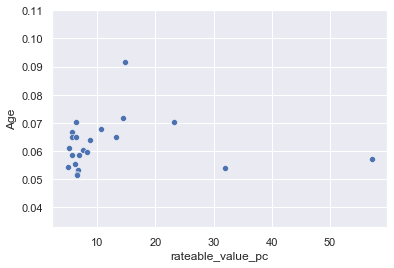

In [1082]:
sns.scatterplot(x='rateable_value_pc',y='Age',data=data_merged)

### Spearman correlation

As any statistics text will tell you, there are many different ways to compute correlation between variables and depending on your research some will be more valid then others. 

Pearson takes into accounts the differences between the number of cats and dogs. But imagine, that I care are more if I spot more of these animals on the same day. In this case I care more about the rank correlation. 
**[explain a bit better]**

We compute this using the Spearman rank correlation.

In [1083]:
v1_ranked = {v:i+1 for i,v in enumerate(sorted(v1))}
v1_rank = [v1_ranked[i] for i in v1]
v1, v1_rank

([1, 3, 5, 7, 2, 6], [1, 3, 4, 6, 2, 5])

In [1084]:
v2_ranked = {v:i+1 for i,v in enumerate(sorted(v2))}
v2_rank = [v2_ranked[i] for i in v2]
v2_rank

[1, 3, 6, 5, 2, 4]

In [1085]:
mean_v1 = np.mean(v1_rank)
mean_v2 = np.mean(v2_rank)

In [1086]:
nominator = np.sum([(i1 - mean_v1)*(i2 - mean_v2) for i1,i2 in zip(v1_rank,v2_rank)])

In [1087]:
denominator = np.std(v1_rank) * np.std(v2_rank) * len(v2_rank)

In [1088]:
nominator/denominator

0.8285714285714286

In [1089]:
pd.Series(v1).corr(pd.Series(v2), method='spearman')

0.8285714285714287

In [1090]:
data_merged['Age'].corr(data_merged['rateable_value_pc'],method='spearman')

0.20293964355004646

Even those who don't engage with statistics, have heard that correlation doesn't mean causation, and is often called 'spurious'. 
Correlation doesn't mean that two variables are associated in the 'real world' (and the opposite: the lack of correlation doesn't mean there is no meaningfull relation between variables).

There is even a website on this topic: https://www.tylervigen.com/spurious-correlations

Be careful when making claims based on the correlation. As often, the statistsical experiment won't give you an answer to your question. There is no simple way to determine if a correlation is spurious, this depends on your domain and theoretical knowledge.


# Linear Regression

Whereas correlation tells you that two variables are related (albeit in a very superficial way) you can not tell more besides the fact the when X goes up we expect Y to do the same. If I see more dogs, I'm also expecting to notice more cats.

Regression modelling on the other hand will tell us more about the mechanistic relation between two variables: how many cats do I expect to see after on a day where I 

The mechanistic relationship allows us to predict a phenomena based on a number of what are usually called independent of predictor variables.

Returning to our example of age and wealth (goodby doggies, you were very helpful), we'd like to see if we can predict the average age (response) in a district given the rateable value per capita (predictor).

Notice here that we have to rely on common sense and domain expertise to construct model that make sense. We could also model the reverse, assuming that populating an area with younger people will affect rateable value. Of course, that also make sense in some universe and could be called reverse causality. 

However, in the way we framed the research (and again this a construction and based on construct validity) we framed as wealth having an impact on age: in poor district the people die younger, people dying younger doesn't make a place poorer. 

R -> A

and not 

R <- A

But these are assumption, (questionable) projections on the data. Oftentimes, when reading a historical paper that usess statistical methods, it is often more important to critically look at the relation between narrative and method (what is data supposed to capture (or mean) and how is combined into a causal theory).

Let's first discuss what a regression model does, before we continue with a more detailed discussion on how to run a regression model.

In it's simplest form a linear model we try to predict a value (age) based on a linear combination of another valie (rateable value per capita). We want to predict the former using the latter.

Using `seaborn` we can make a dispersion plot where each observation is turned into a point on the figure. The x-axis (`x=`) shows the rateable value, the y-axis (`y=`) age. 

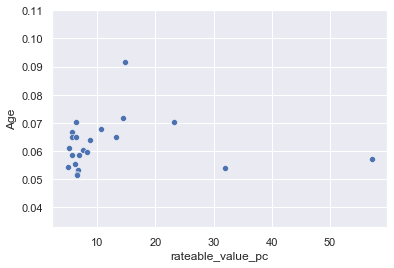

In [1091]:
sns.scatterplot(x='rateable_value_pc',
                y='Age',
                data=data_merged)

How? Looking at the scatterplot the relation between the two is not obvious. In it's simplest, a linear regression will model the relation between x and y by drawing a line best "fits" the data, i.e. closest to the observations as possible.

From your high school you may remember the equation of a line.

y = a + b*x

age = intercept + slope * rateable value per capita

a is intercept, the point where the line crosses to y-axis if x is zero. You may also think as: what age do we expect for a place with zero rateable value.

b is the slope, and determinss the strength the y and x: how much change to we expect in y after one unit change x. What how many years do we expect to add moving from a place with rateable value 3 to 4 for example.

We know age and rateable value. We use these data to estimate the value of a (intercept) and b slope. We have a closer look at this later.

For now we plot the result, i.e. what the model thinks the line should look like after observing the data.

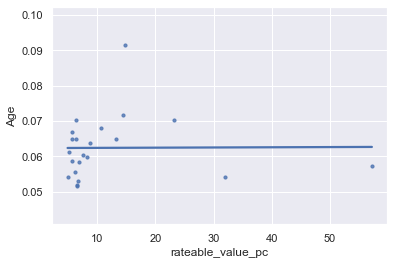

In [1092]:
sns.regplot(x="rateable_value_pc", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

The line plotted is based on a linear regression and is the line that fits best all observations. 

The fact that models "work", doesn't nesicarilly mean they make sense. A best fit can still be pretty bad.

As you observe there are many values cluttered together in the lower range and only a few at the right hand side of the figure.

We can improve the fit by transforming the values on a-axis. We take the natural logarthim of the rateable value per capite, this will make small differences (pull apart the observation at the lower end of independent variable) and large difference smaller (push those places at the far right to the other observations).

But what is the natural logarithm? Let's have a look, what happens if we take the logarithm of 1000

In [1093]:
np.log(1000)

6.907755278982137

We get a number close to 7 (i.e. 6.907755278982137). What does this mean? The logarithm is inverse of exponentation: if x = log(y) and y = exp(x), or sticking to our example, if np.log(1000) produces 6.907755 then 
e<sup>6.90775</sup> will approximately equal 1000 (not exactly as rounded the numbers.
`e` is called Euler's number and is approximately equal to 2.71828182845904523536028747135266249775724709369995 according to [Wikipedia]. You can check this for yourself

In [1094]:
np.exp(6.907755278982137)

999.9999999999998

In [1095]:
np.power(2.71828,6.907755278982137)

999.9953534904313

But why we would we do this, why would we effectively rescale one our variables? This partly solves the problem of dispersion: the logarithmic scale can make linear modelling easier, as sometimes value becomes linear on a logarithmic scale. Below we first show a toy example using numbers that become increasingly separated.

In [1096]:
x_1 = [10,100,1000,10000]

As you seen it is very difficult to model sudden gaps with a linear line...

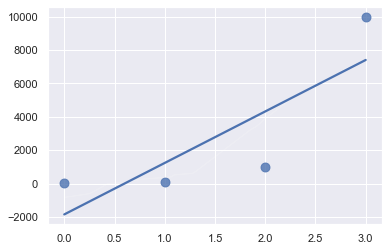

In [1097]:
sns.regplot(x=list(range(len(x_1))), y=x_1, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

However, if we take the logarith, these values become neatly linear.

In [1098]:
x_2 = np.log([10,100,1000,10000])

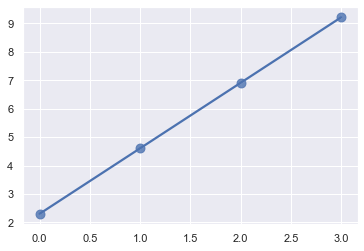

In [1099]:
sns.regplot(x=list(range(len(x_2))), y=x_2, 
                 scatter_kws={"s": 80},
                 order=1,ci=False)

Even though 'real' data never fits patterns as neatly, we observe similar changes when inspecting the rateable value per capita variable.

In [1100]:
data_merged.sort_values('rateable_value_pc',inplace=True)

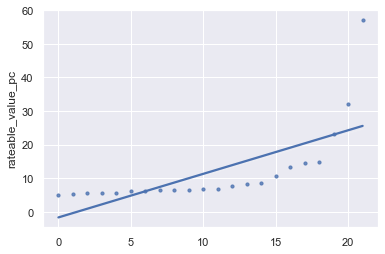

In [1101]:
sns.regplot(x=list(range(22)), y=data_merged["rateable_value_pc"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

In [1102]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc'])

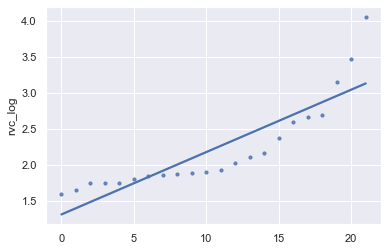

In [1103]:
sns.regplot(x=list(range(22)), y=data_merged["rvc_log"], 
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Both lines don't fit the data perfectly, however the later one does seem approximate the actual observed values better.

Also, if now model age as a function of the logged rateable value, we 

In [1104]:
data_merged['rvc_log'] = np.log(data_merged['rateable_value_pc'])

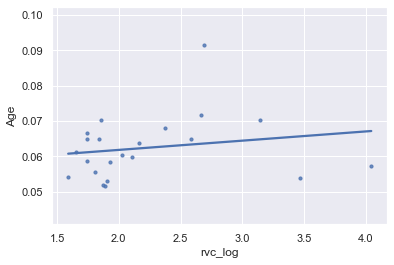

In [1105]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Later in this lecture we have a closer look and actually quantify the difference logging makes with respect to the goodness of fit. For now, a visual inspection suffices. Even though, we could add, that logging also improved the correlation between the two variables.

In [1106]:
data_merged['rateable_value_pc'].corr(data_merged['Age'],method='pearson')

0.007468551985364711

In [1107]:
data_merged['rvc_log'].corr(data_merged['Age'],method='pearson')

0.18591858770172157

Generally logging values doesn't harm, but you'll have to be careful as it influences your interpretation and the predictions to model will make. So you have to be carefull nonetheless. 

A closer look at the scatterplot and the data shown that two (or three) places have a signficantly higher rateable value: Holborn and Westminster, and also Marelybone. This is confirmed by the boxplot below.  

How to approach these observation: one albeit, very problematich approach is to consider them as outlier and remove them from the datasets.

This is a classical example of where interventions need to motivated or at least explained by domain expertise. Excluding the Holborn and Westminster has a huge effect on the slope of the regression line.

In [1108]:
data_merged[['borough','rateable_value_pc']]

,borough,rateable_value_pc
2,Bethnal Green,4.9
3,Camberwell,5.2
18,Poplar,5.7
13,Islington,5.7
9,Hackney,5.7
7,Fulham,6.1
15,Lambeth,6.3
16,Lewisham,6.4
23,Stepney,6.5
27,Woolwich,6.6


/usr/local/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


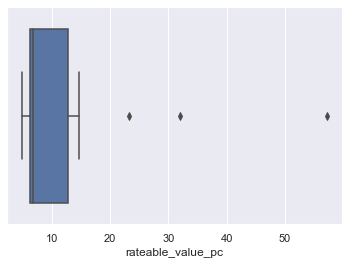

In [1109]:
sns.boxplot(data_merged.rateable_value_pc)

Let's remove these districts to how they affect our model.

In [1110]:
data_wo_outliers = data_merged[~data_merged.borough.isin(['Westminster',"Holborn"])]

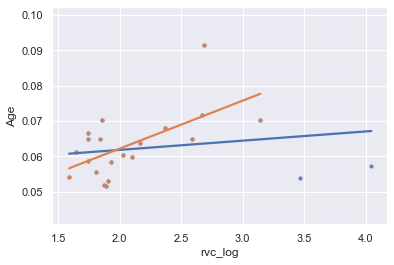

In [1111]:
sns.regplot(x="rvc_log", y="Age", data=data_merged,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

sns.regplot(x="rvc_log", y="Age", data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

In the figure the orange line shows the regression line after removing the so-called 'outliers'. You see how throwing away information (i.e. observations) is tricky thing: yes it easier to model the relationship between the variables linearly. However, this comes at a cost, we won't be able to accurately say something about the wealthier districts, and (if we believe the orange 

However, if you're only interested in predicting the age for a certain type of boroughs, and have good reasons to believe the ones we throwns are qualitatively different and should be considered as seperate case studies, then yes, it could be allow the consider only certain boroughs.

In any case, it is important to know the a few place carry a lot of weight, i.e. the influence the slope of the regression lines substantially.


Again, here, or domain expertise has priority over statistics, and the statistics alone can not provide you with the answer of how to proceed and analyse your data.

In [1112]:
print(data_merged['rvc_log'].corr(data_merged['Age']))
print(data_wo_outliers['rvc_log'].corr(data_wo_outliers['Age']))


0.18591858770172157
0.6144105064733825


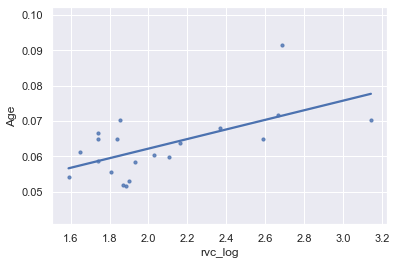

In [1113]:
sns.regplot(x="rvc_log", y="Age", 
                 data=data_wo_outliers,
                 scatter_kws={"s": 10},
                 order=1,ci=False)

Hopefully, this largely visual introduction demonstrated the use of linear regression and some of problems that you are likely to encounter. Again, we'd like to stress that often the solution to these issues often require you to lean on your domain expertise as historian. To solutions are often not statistical. 

History always should come before statistics.

## Linear Regression (a closer look)

In the preceding section we approached the idea of linear regression from a more intuitive, visual perspective. In this section we have a closer look at the reading the results and outputs that accompany regression analysis. 

Performing a linear regression is rather straightforward with  the `statsmodels` package in Python. There a just a few things to be careful about. First we define the response variable, in this case 'Age'.

In [1114]:
Y = data_merged['Age']

Next we select the independent variable from the dataframe.

In [1115]:
X = data_merged['rateable_value_pc']

Now there is one small trick to keep in mind. As said earlier the equation of a simple linear model is 

$y = a + b*x$

In this equation we know both $y$ and $x$ these are data we observed. We don't know $a$ and $b$, these are the parameters we want to learn from the data. 

Running a regression will return an estimate for $a$ and $b$ most consistent with the observed data. 

Because we want `statsmodels` to estimate both the intercept $a$ and the slope $b$ we have to add one more column with only a constant to `X`. Luckily this is really straightforwards with the `add_constant` function.

In [1116]:
X = sm.add_constant(X)
X 

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,rateable_value_pc
2,1.0,4.9
3,1.0,5.2
18,1.0,5.7
13,1.0,5.7
9,1.0,5.7
7,1.0,6.1
15,1.0,6.3
16,1.0,6.4
23,1.0,6.5
27,1.0,6.6


Now we are ready instantiate the model and fit it. We save the result of the fitted model in the `results` variable.

In [1117]:
model = sm.OLS(Y,X) # instantiate model
results = model.fit() # fit model

Applying the `.summary()` method to the fitted model will print a rather large report.

In [1118]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.050
Method:                 Least Squares   F-statistic:                  0.001116
Date:                Fri, 21 Jan 2022   Prob (F-statistic):              0.974
Time:                        00:36:03   Log-Likelihood:                 72.917
No. Observations:                  22   AIC:                            -141.8
Df Residuals:                      20   BIC:                            -139.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0623      0.003     22.265      0.000       0.056       0.068
rateable_value_pc  5.573e-06      0.000      0.033      0.974      -0.000       0.000
==============================================================================
Omnibus:                       15.000   Durbin-Watson:                   1.133
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.453
Skew:                           1.449   Prob(JB):                     0.000441
Kurtosis:                       5.909   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Most import values (for our purposes) are at the top right and the midde lines that report on the coefficients (`const` and `rvc_log`). Let's start with the latter, as these are most influential in the interpretations based on regression modelling.


`const 27.4098` means that for place with zero rateable value, we expect the average age to be around 25.2. This is the estimate for the intercept, i.e. the value of y (Age) when x (rateable value) = 0. 
`rateable_value_pc 0.0429` this is an estimate of the slape, the increase in y for one unit change in y: for example if the rateable value changes from 1 to 2 we expect the mean age to increase with 0.04 years. 

Now let's look at the other statistics reported here for these coefficients. Continuing with the estimate for `rateable_value_pc` the p-value is around 0.1 higher than the traditional 0.5 threshold commonly used in statistics. And the confidence intervals range from -0.010 to 0.096. 

Notice that this 0 is included in the confidence interval. A slope of zero means a horizontal line, and actually no change in y for x. The possibiliy that x and y are not related in any positive or negative way is well within the range of possibilities.

p-values and confidence remain rather abstract and difficult to explain, and statisticians tend to doubt their use. In human language, these number tells you how confident the model is about where to draw a line to best fit all observed variables. It is really shore that the intercepts is higher than zero, which is not surprising and probably somewhere between `26.523`	`28.296`. 

However, it is less confident about the slope, which can go down (-0.010) as well as up (0.096).

What happens if we fit a new model with logged rateable values values.

In [1119]:
Y_2 = data_merged['Age']
X_2 = data_merged['rvc_log']
X_2 = sm.add_constant(X_2)
model_2 = sm.OLS(Y_2,X_2) # instantiate model
results_2 = model_2.fit() # fit model

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [1120]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.7161
Date:                Fri, 21 Jan 2022   Prob (F-statistic):              0.407
Time:                        00:36:05   Log-Likelihood:                 73.303
No. Observations:                  22   AIC:                            -142.6
Df Residuals:                      20   BIC:                            -140.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0566      0.007      7.964      0.000       0.042       0.071
rvc_log        0.0026      0.003      0.846      0.407      -0.004       0.009
==============================================================================
Omnibus:                       12.427   Durbin-Watson:                   1.212
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.412
Skew:                           1.259   Prob(JB):                      0.00333
Kurtosis:                       5.472   Cond. No.                         9.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Using the log-scale, change coefficients quite a lot especially for the rateable value. The model is now more certain the relation is postive and does not include the zero in the range of possibilities. 

For each change in x (the log of rateable value) we expect to add one year and a bit to `y` (1.2195). It is now a bit more difficult to understand, as the absolute change is bigger with each step in `x`.

In [1121]:
np.exp(2), np.exp(3), np.exp(4)

(7.38905609893065, 20.085536923187668, 54.598150033144236)

This means that the model thinks that change in age is the same when going from a place with rateable value 7 to 20 as is transitioning from 20 to 54.

What all the statistics for the `const` and `rvc_log` are more formal ways for conveying where the model thinks the line should be.

We can make these results more intuitive using a "bootstrap" method. We construct the mean and confidence intervals repeatin the following steps, let's say 1000 times:
- sample a few observations from the data (50% in each iterations)
- fit the model and record the values for the intercept and the slope
- plot the line using these value or collect them and compute the 2.5 and 97.5 percentile range.

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


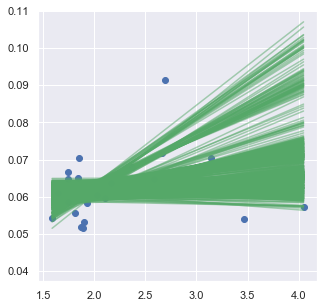

In [1122]:
#data_merged.sort_values('re',inplace=True)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
beta = []

for _ in range(1000):
    dms = data_merged.sample(frac=.66)
    Y_ = dms['Age']
    X_ = dms['rvc_log']
    X_ = sm.add_constant(X_)
    model_ = sm.OLS(Y_,X_)
    results_ = model_.fit() 
    beta.append(results_.params['rvc_log'])

    ax.plot(data_merged['rvc_log'], results_.params['const'] + (data_merged['rvc_log']*results_.params['rvc_log']) , '-g',alpha=.5)


0.025   -0.000718
0.975    0.016180
dtype: float64

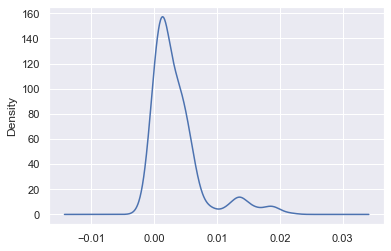

In [1123]:
pd.Series(beta).plot(kind='density')
pd.Series(beta).quantile([.025,.975])

The values are not exactly the same because we have a small sample and only ran a few iterations. However it gives more intuitive way of understanding of what the p-values and confidence intervals mean. Instead of bootstrapping you can also compute the formula-based intervals with `statsmodels`.

In [1124]:
pred = results_2.get_prediction(X_2)
df_pred = pd.DataFrame(pred.conf_int())
df_pred['mean'] = pred.predicted_mean

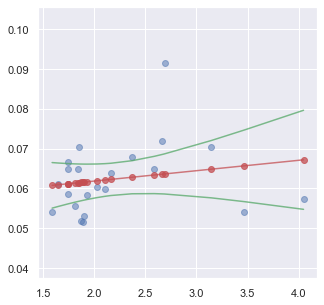

In [1125]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(data_merged['rvc_log'], 'Age',data=data_merged,alpha=.5)
ax.plot(data_merged['rvc_log'], df_pred['mean']  , '-ro',alpha=.75)
ax.plot(data_merged['rvc_log'], df_pred[0]  , '-g',alpha=.75)
ax.plot(data_merged['rvc_log'], df_pred[1]  , '-g',alpha=.75)

Please notice that coeficients and their confidence intervals are estimates of the line not the actual data. These are, as you can see, well outside the range given by the predicted values and their confidence intervals.

The `.summary()` method provides other statistics that help you understanding how well the model performs.

In [1126]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.7161
Date:                Fri, 21 Jan 2022   Prob (F-statistic):              0.407
Time:                        00:36:12   Log-Likelihood:                 73.303
No. Observations:                  22   AIC:                            -142.6
Df Residuals:                      20   BIC:                            -140.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0566      0.007      7.964      0.000       0.042       0.071
rvc_log        0.0026      0.003      0.846      0.407      -0.004       0.009
==============================================================================
Omnibus:                       12.427   Durbin-Watson:                   1.212
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.412
Skew:                           1.259   Prob(JB):                      0.00333
Kurtosis:                       5.472   Cond. No.                         9.98
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

`RMSE`

In [1127]:
pred = results_2.get_prediction(X_2)
Y_hat = pred.predicted_mean 
var_pred = [(y - y_hat)**2 for y,y_hat in zip(Y,Y_hat)] 

In [1128]:
Y_hat

array([0.06076238, 0.06091739, 0.06115688, 0.06115688, 0.06115688,
       0.0613338 , 0.06141795, 0.06145904, 0.06149948, 0.06153931,
       0.06157853, 0.06165526, 0.06190732, 0.06210553, 0.06225993,
       0.0627997 , 0.06336712, 0.06357441, 0.06362819, 0.0648185 ,
       0.06565737, 0.06717248])

`R-squared`

In [1129]:
np.sqrt(np.sum(var_pred) / len(Y))

0.008643794286218545

In [1130]:
var_total = [(y - np.mean(Y))**2 for y,y_hat in zip(Y,Y_hat)] 

In [1131]:
round(1 - (sum(var_pred)/sum(var_total)),3)

0.035

Text(0, 0.5, 'standardized residuals')

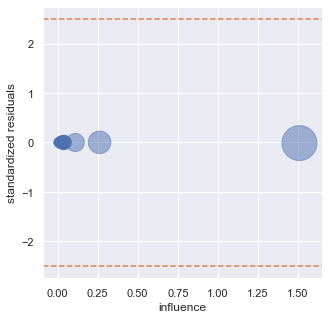

In [1132]:
from statsmodels.stats.outliers_influence import OLSInfluence
influence = OLSInfluence(results)
fig, ax = plt.subplots(figsize=(5, 5))
ax.axhline(-2.5, linestyle='--', color='C1')
ax.axhline(2.5, linestyle='--', color='C1')
ax.scatter(influence.cooks_distance[0], influence.influence,
s=1000 * np.sqrt(influence.cooks_distance[0]),
alpha=0.5)
ax.set_xlabel('influence')
ax.set_ylabel('standardized residuals')

In [1133]:
data_merged.iloc[np.argmax(influence.hat_diag_factor)]

Age                     0.057264
Sex                         8033
borough              Westminster
rateable_value_pc           57.2
rvc_log                 4.046554
Name: 26, dtype: object

In [1134]:
Y_woo = data_wo_outliers['Age']
x_woo = data_wo_outliers['rvc_log']
#X_woo = np.column_stack((x_woo, np.log(data_wo_outliers['index'])))
X_woo = sm.add_constant(x_woo)
model_woo = sm.OLS(Y_woo,X_woo)
results_woo = model_woo.fit()

In [1135]:
results_woo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     10.92
Date:                Fri, 21 Jan 2022   Prob (F-statistic):            0.00395
Time:                        00:36:16   Log-Likelihood:                 70.717
No. Observations:                  20   AIC:                            -137.4
Df Residuals:                      18   BIC:                            -135.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0351      0.009      4.065      0.001       0.017       0.053
rvc_log        0.0135      0.004      3.304      0.004       0.005       0.022
==============================================================================
Omnibus:                        7.001   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.030   Jarque-Bera (JB):                4.480
Skew:                           1.050   Prob(JB):                        0.106
Kurtosis:                       3.982   Cond. No.                         13.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

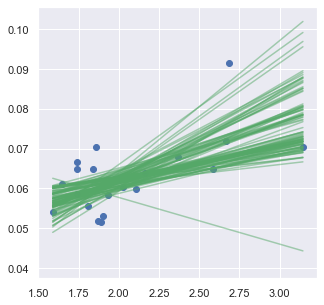

In [1139]:
data_wo_outliers.sort_values('rvc_log',inplace=True)
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_wo_outliers)
beta = []
for _ in range(100):
    dms = data_wo_outliers.sample(frac=.5)
    Y = dms['Age']
    X = dms['rvc_log']
    X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit() 
    beta.append(results.params['rvc_log'])

    ax.plot(data_wo_outliers['rvc_log'], results.params['const'] + (data_wo_outliers['rvc_log']*results.params['rvc_log']) , '-g',alpha=.5)


0.025    1.624484
0.975    4.239491
dtype: float64

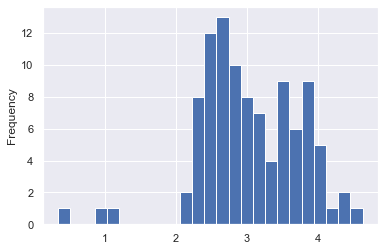

In [1137]:
pd.Series(beta).plot(kind='hist',bins=25)
pd.Series(beta).quantile([.025,0.975])

In [983]:
wo_outliers['predictions'] = results.predict(X)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [985]:
data_merged

,Age,Sex,borough,rateable_value_pc,rvc_log
2,0.117463,31593,Bethnal Green,4.9,1.589235
3,0.131304,63060,Camberwell,5.2,1.648659
18,0.125373,40838,Poplar,5.7,1.740466
13,0.138770,81826,Islington,5.7,1.740466
9,0.138932,65687,Hackney,5.7,1.740466
7,0.123097,60489,Fulham,6.1,1.808289
15,0.138292,73511,Lambeth,6.3,1.840550
16,0.138958,32902,Lewisham,6.4,1.856298
23,0.114748,14083,Stepney,6.5,1.871802
27,0.111003,31909,Woolwich,6.6,1.887070


In [986]:
Y_mr = data_merged['Age']
x_mr = data_merged['rvc_log']
X_mr = np.column_stack((x_mr, np.log(data_merged['Sex'])))
X_mr = sm.add_constant(X_mr)
model_mr = sm.OLS(Y_mr,X_mr)
results_mr = model_mr.fit()

In [987]:
results_mr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.116
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.241
Date:                Fri, 21 Jan 2022   Prob (F-statistic):              0.311
Time:                        00:31:48   Log-Likelihood:                 64.918
No. Observations:                  22   AIC:                            -123.8
Df Residuals:                      19   BIC:                            -120.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0362      0.075      0.484      0.634      -0.120       0.193
x1             0.0091      0.006      1.555      0.136      -0.003       0.021
x2             0.0072      0.006      1.152      0.264      -0.006       0.020
==============================================================================
Omnibus:                       10.682   Durbin-Watson:                   1.095
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                8.768
Skew:                           1.174   Prob(JB):                       0.0125
Kurtosis:                       5.013   Cond. No.                         280.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [988]:
data_merged['predictions'] = results_mr.predict(X_mr)

In [989]:
len(predictions),len(data_merged)

(22, 22)

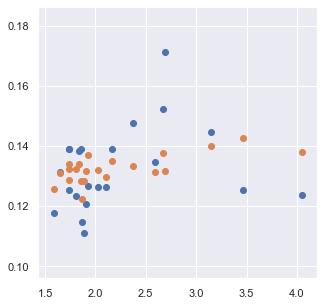

In [990]:

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=data_merged)
ax.scatter('rvc_log', 'predictions',data=data_merged)

### Categorical Variables

In [991]:
import statsmodels.formula.api as smf
age_by_dist_gen.columns = ['Age','Count']
temp = age_by_dist_gen.reset_index()

In [992]:
temp

,RegDist,Sex,Age,Count
0,Bethnal Green,F,25.920963,16081
1,Bethnal Green,M,25.613501,14458
2,Bethnal Green,U,20.766603,1054
3,Camberwell,F,27.986109,32898
4,Camberwell,M,26.708931,28172
...,...,...,...,...
85,Whitechapel,M,26.254569,9357
86,Whitechapel,U,24.051316,760
87,Woolwich,F,26.653639,15250
88,Woolwich,M,26.311769,15643


In [878]:
X_i = temp_m[['rvc_log', 'F','log_count']].values
sm.add_constant(X_i)

array([[ 1.        ,  1.58923521,  1.        ,  9.68539373],
       [ 1.        ,  1.58923521,  0.        ,  9.57900317],
       [ 1.        ,  1.58923521,  0.        ,  6.96034773],
       [ 1.        ,  1.64865863,  1.        , 10.40116714],
       [ 1.        ,  1.64865863,  0.        , 10.24608386],
       [ 1.        ,  1.64865863,  0.        ,  7.59588992],
       [ 1.        ,  2.68784749,  1.        ,  9.21333588],
       [ 1.        ,  2.68784749,  0.        ,  8.94754602],
       [ 1.        ,  2.68784749,  0.        ,  6.41345896],
       [ 1.        ,  1.80828877,  1.        , 10.36703287],
       [ 1.        ,  1.80828877,  0.        , 10.19283074],
       [ 1.        ,  1.80828877,  0.        ,  7.59287029],
       [ 1.        ,  2.02814825,  1.        , 10.02976772],
       [ 1.        ,  2.02814825,  0.        ,  9.93522844],
       [ 1.        ,  2.02814825,  0.        ,  7.30988149],
       [ 1.        ,  1.74046617,  1.        , 10.47647074],
       [ 1.        ,  1.

In [846]:
temp_m = temp.merge(data_merged[['borough','rvc_log','rateable_value_pc']], left_on='RegDist',right_on='borough')

In [848]:
temp_m['F'] = pd.get_dummies(temp_m['Sex'])['F']

In [867]:
temp_m['log_count'] = np.log(temp_m['Count'])

In [872]:
model_i = smf.ols(formula='Age ~ rvc_log + F + log_count', data=temp_m)
results_i = model_i.fit()

In [873]:
results_i.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     53.29
Date:                Fri, 21 Jan 2022   Prob (F-statistic):           3.72e-17
Time:                        00:15:46   Log-Likelihood:                -110.93
No. Observations:                  66   AIC:                             229.9
Df Residuals:                      62   BIC:                             238.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.2655      1.548      6.632      0.000       7.171      13.360
rvc_log        2.2421      0.273      8.201      0.000       1.696       2.789
F              0.6751      0.408      1.654      0.103      -0.141       1.491
log_count      1.2636      0.148      8.531      0.000       0.967       1.560
==============================================================================
Omnibus:                        6.197   Durbin-Watson:                   1.056
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                7.719
Skew:                           0.314   Prob(JB):                       0.0211
Kurtosis:                       4.553   Cond. No.                         89.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [885]:
temp_m['predictions'] = results_i.predict(temp_m[['rvc_log', 'F','log_count']])

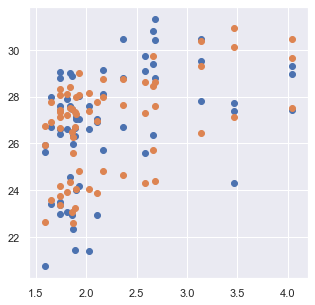

In [887]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter('rvc_log', 'Age',data=temp_m)
ax.scatter('rvc_log', 'predictions',data=temp_m)

In [486]:
df_fm = df[(df.Sex.isin(['F','M'])) & (df.RegDist=='Stepney')]

In [487]:
Y = df_fm['Age']
X = df_fm['F']
#X = np.column_stack((x, x ** 2,x ** 3))
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [488]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    Age   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.119
Date:                Tue, 18 Jan 2022   Prob (F-statistic):              0.290
Time:                        17:40:32   Log-Likelihood:                -58242.
No. Observations:               13459   AIC:                         1.165e+05
Df Residuals:                   13457   BIC:                         1.165e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.3201      0.224    117.353      0.000      25.880      26.760
F             -0.3343      0.316     -1.058      0.290      -0.954       0.285
==============================================================================
Omnibus:                      892.983   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1018.276
Skew:                           0.653   Prob(JB):                    7.66e-222
Kurtosis:                       2.668   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""